In [12]:
import scipy
import re
filepath = "data/raw/cwru/97.mat"
matlab_file = scipy.io.loadmat(filepath)
keys = re.findall(r'X\d{3}_[A-Z]{2}_time', str(matlab_file.keys()))
print(keys)
data = matlab_file["X097_DE_time"]
data = data.squeeze()[:48000]
data.shape

['X097_DE_time', 'X097_FE_time']


(48000,)

In [14]:
from PIL import Image

image = Image.open("data/temp/007/N/97_0.png")
largura, altura = image.size
print(f"Largura: {largura}, Altura: {altura}")

Largura: 775, Altura: 462


In [13]:
from scripts.generate_spectrogram import generate_spectrogram

generate_spectrogram(data, "spectro_test.png", 48000)

In [4]:
import torch 
import torchvision 
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'torch'

In [ ]:



batch = 64


# based on the choice, change the cifar10 or mnist
a = 1
if a == 1:
    # Define transformations
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
        transforms.ToTensor()  # Convert to tensor
    ])
    # Load the CIFAR-10 dataset
    train_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform)
    test_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform)
    dim = 1024

else:
    transform = transforms.Compose([
        transforms.ToTensor()  # Convert images to tensor
         # Normalize with mean 0.5 and std 0.5 for single channel (MNIST is grayscale)
    ])
    train_dataset = torchvision.datasets.MNIST(
        root='./data', train=True, download=True, transform=transform)
    test_dataset = torchvision.datasets.MNIST(
        root='./data', train=False, download=True, transform=transform)
    dim = 784

# DataLoader
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch, shuffle=False)       

# Visualize some grayscale images
def imshow(img):
    img = img.squeeze(0)  # Remove channel dimension for grayscale
    plt.imshow(img, cmap='gray')
    plt.axis('off')


class VAE(nn.Module):
    def __init__(self,k, dim ):
        super(VAE, self).__init__()
        self.k = k
        self.encoder_fc1 = nn.Linear(dim, 256)
        self.encoder_mean = nn.Linear(256, self.k)
        self.encoder_var = nn.Linear(256, self.k)
        
        self.decoder_fc1 = nn.Linear(self.k, 256)
        self.decoder_fc2 = nn.Linear(256, dim)
        
    def encoder(self, x):
        x = torch.relu(self.encoder_fc1(x))

        # output the mean and log variance
        # x is in dimension of batch x 64
        mean = torch.relu(self.encoder_mean(x))
        log_variance = torch.relu(self.encoder_var(x))
        return mean, log_variance
    
    def decoder(self, x):
        x = torch.sigmoid(self.decoder_fc1(x))
        x = torch.sigmoid(self.decoder_fc2(x))
        return x
        
    def reparam(self,mu, log_variance):
        eps = torch.normal(0,1,size = (1,self.k))
        if torch.cuda.is_available():
            mu = mu.cuda()
            log_variance = log_variance
            eps = eps.cuda() 
        std = torch.exp(0.5 * log_variance)
        return mu + eps * std
        
    def forward(self, x):
        if torch.cuda.is_available():
            x = x.cuda()
        # flatten the x
        x = x.squeeze()
        x = x.view(x.size(0),-1)
        mean, log_variance = self.encoder(x)
        reparam_out = self.reparam(mean, log_variance)
        decoder_out = self.decoder(reparam_out)
        return decoder_out, mean, log_variance
    
    def generate_sample(self, x):
        if torch.cuda.is_available():
            x = x.cuda()
        x = x.view(x.size(0),-1)
        mean, log_variance = self.encoder(x)
        reparam_out = self.reparam(mean, log_variance)
        decoder_out = self.decoder(reparam_out)
        return decoder_out, mean, log_variance

# loss function 
def vae_loss(output, target, mean, log_variance, k, beta):
    if torch.cuda.is_available():
        output = output.cuda()
        target = target.cuda()
        mean = mean.cuda()
        log_variance = log_variance.cuda()
    # mean = batch x k
    # log_variance = batch x k
    # kl_dis = batch x 1
    kl_dis = -0.5 * torch.sum(1 + log_variance - mean ** 2 - torch.exp(log_variance), dim=1)
    
    #MSE = batch x (pixel*pixel)
    MSE = 1/2*(output - target)**2 
    # MSE = batch x 1
    MSE = torch.mean(MSE, dim = 1)*dim
    # MSE + kl_dis = batch x 1
    return torch.mean(MSE + kl_dis * beta), torch.mean(MSE), torch.mean(kl_dis)

def train_epoch(VAE_model, train_dataloader, vae_loss,
                optimizer, beta,k):
    epoch_loss = 0
    for train_idx, (features, labels) in enumerate(train_dataloader):
        if torch.cuda.is_available():
            features = features.cuda()
            labels = labels.cuda()
            VAE_model = VAE_model.cuda()
        optimizer.zero_grad()
        # create target
        target = features.view(features.size(0), -1)
        # feed through the encoder
        output, mean, log_variance = VAE_model(features)
        total_loss, MSE_loss, kl_loss = vae_loss(output, target, mean, log_variance, k, beta)
        total_loss.backward()
        optimizer.step()
        # batch loss
        if train_idx % 128 == 0:
            print(f"batch loss is: {total_loss.item()}. MSE loss is {MSE_loss}. kl_loss is {kl_loss}")
        epoch_loss += total_loss.item()  
    return epoch_loss    
    
################# training loop ###############
k = 16
vae_model = VAE(k = k, dim = dim)
vae_model = vae_model.cuda()
epoches = 3
beta = 5e-1 #0.05
sample_num = 5
# start train
vae_model.train()
optimizer = torch.optim.Adam(vae_model.parameters())
for epoch in range(epoches):
    print(f'For epoch of {epoch}')
    epoch_loss = train_epoch(vae_model, train_loader, vae_loss, optimizer, beta, k)

# freeze the model/inference
vae_model.eval()

fig, (axes1, axes2) = plt.subplots(2, sample_num, figsize = (3,3))
for i in range(sample_num): 
    # get the data. 
    image, label = test_dataset[i*10]
    axes2[i].imshow(image.squeeze(0).detach().cpu(), cmap='gray')  # Detach to remove gradients and use cpu if on cuda
    axes2[i].axis('off')  # Turn off axis
    
    generated_image, mu, var = vae_model.generate_sample(image)
    print(mu)
    print(torch.exp(var*0.5))
    # reshape the generated image
    image_samples = generated_image.view(generated_image.size(0), int(dim**0.5),int(dim**0.5))
    axes1[i].imshow(image_samples.squeeze(0).detach().cpu(), cmap='gray')  # Detach to remove gradients and use cpu if on cuda
    axes1[i].axis('off')  # Turn off axis
plt.show()

ModuleNotFoundError: No module named 'torch'

Example of VAE

# Datasest

## CWRU

Os dados utilizados neste experimento são os listados na tabela abaixo.

| SEVERITY | 0 hp / 1797 rpm   | 1 hp / 1772 rpm  | 2 hp / 1750 rpm  | 3 hp / 1730 rpm  | Class |
|----------|-------|-------|-------|-------|-------|
| 0.007”   | 109   | 110   | 111   | 112   | I     |
|          | 122   | 123   | 124   | 125   | B     |
|          | 135   | 136   | 137   | 138   | O     |
| 0.014”   | 174   | 175   | 176   | 177   | I     |
|          | 189   | 190   | 191   | 192   | B     |
|          | 201   | 202   | 203   | 204   | O     |
| 0.021”   | 213   | 214   | 215   | 217   | I     |
|          | 226   | 227   | 228   | 229   | B     |
|          | 238   | 239   | 240   | 241   | O     |

* 12 arquivos de dados para cada classe, sendo 4 para cada nível de severidade, totalizando 36 arquivos de dados.
* Tamanho das amostras:
* Total de amostras por arquivo:
* Total de amostras.

**Condições operacionais**
* Taxa de amostragem: 48 kHz
* Velocidade do eixo: 1797, 1772, 1750 e 1730 RPM
* Carga do motor: 0, 1, 2 e 3 hp

# Especificação do rolamento
* Modelo do rolamento: 6205-2RS JEM SKF
* Número de esferas: 9
* Diâmetro da esfera: 7.94 mm
* Diâmetro primitivo: 39.03 mm


In [1]:
# Importações necessárias para essa sessão
import torch
import torch.nn as nn
import os
import numpy as np
from datasets import CWRU
from utils import BearingFaultFrequencies
from utils import load_yaml

### Amostras

In [34]:

dataset = CWRU()
dataset_name = "CWRU"
data_filter = load_yaml("config/filters_config.yaml")[dataset_name]
metainfo = dataset.metainfo.filter_data(data_filter)
print(f"Quantidade de arquivos de dados: {len(metainfo)}")

sample_size = []
for info in metainfo:
    basename = info["filename"]       
    filepath = os.path.join('data/raw/', dataset_name.lower(), basename+'.mat')
    # print(f"filepath: {filepath}")            
    signal, label = dataset.load_signal_by_path(filepath)
    sample_size.append(signal.shape[0])
print(f"\nIntervalo do tamanho das amostras: {min(sample_size)} - {max(sample_size)}")

# Parâmetros para o cálculo do impulso transiente
number_of_balls = 9
diameter_ball = 7.94
pitch_diameter = 39.03
shaft_speed = 1773 / 60 # converter para (Hz)
sampling_rate = 48000

# Calculo da frequência da falha
bpfo = BearingFaultFrequencies.calculate_bpfo(shaft_speed, number_of_balls, diameter_ball, pitch_diameter)
bpfi = BearingFaultFrequencies.calculate_bpfi(shaft_speed, number_of_balls, diameter_ball, pitch_diameter)
bsf = BearingFaultFrequencies.calculate_bsf(shaft_speed, number_of_balls, diameter_ball, pitch_diameter)
print(f"\nA frequência das falhas das sequintes classes são:")
print(f"I: {bpfi}, O: {bpfo}, B: {bsf}")

# Calculo do impulso transiente
ti_bpfo = sampling_rate / bpfo
ti_bpfi = sampling_rate / bpfi
ti_bsf = sampling_rate / bsf
print(f"\nO comprimento do segmento do impulso trasiente das sequintes classes são:")
print(f"I: {ti_bpfo}, O: {ti_bpfo}, B: {ti_bsf}")

Quantidade de arquivos de dados: 36

Intervalo do tamanho das amostras: 63788 - 491446

A frequência das falhas das sequintes classes são:
I: 160.02653727901614, O: 105.92346272098385, B: 69.62251670871272

O comprimento do segmento do impulso trasiente das sequintes classes são:
I: 453.1573908836254, O: 453.1573908836254, B: 689.4321301371912


### Análise

#### Boxplot

In [3]:
from utils.plots import plot_boxplot

filepath: data/raw/cwru/112.mat


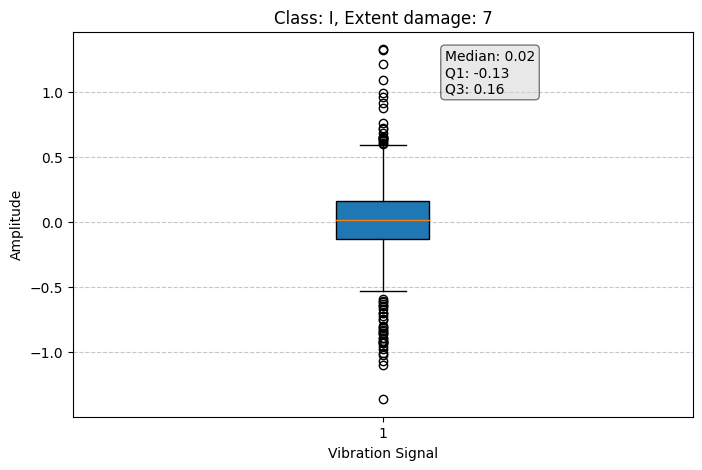

filepath: data/raw/cwru/125.mat


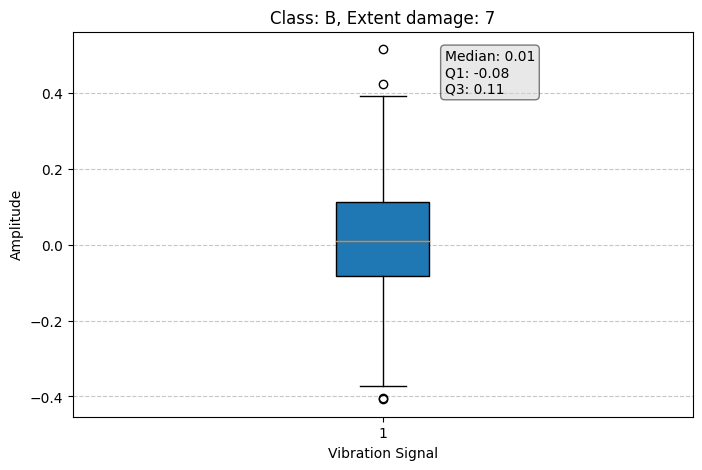

filepath: data/raw/cwru/138.mat


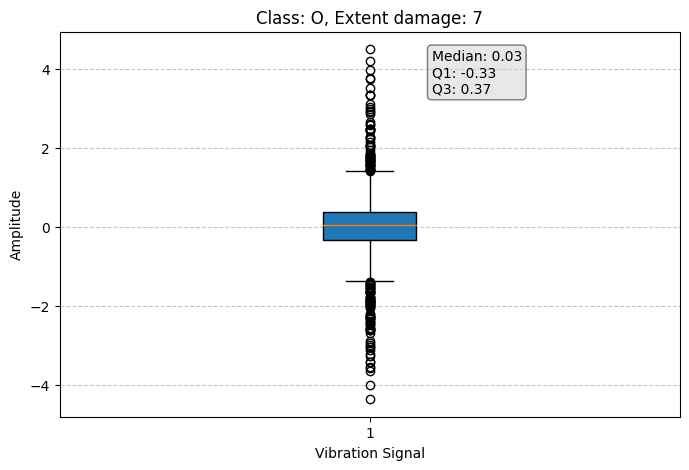

filepath: data/raw/cwru/192.mat


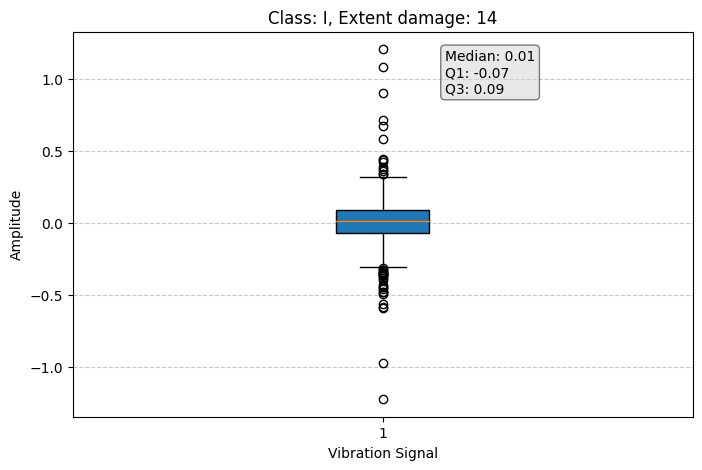

filepath: data/raw/cwru/204.mat


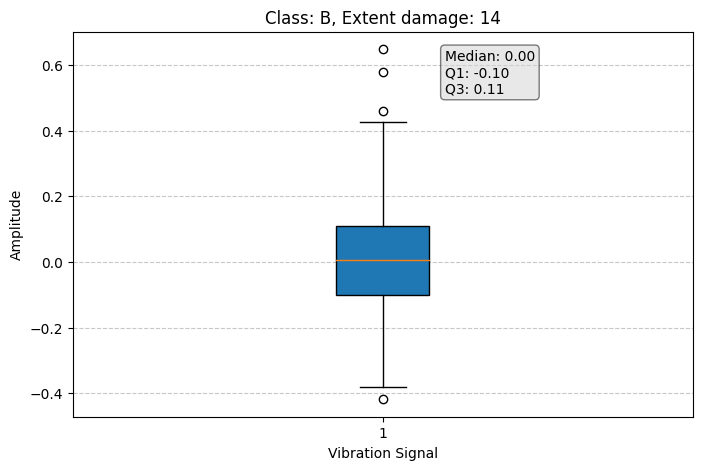

filepath: data/raw/cwru/217.mat


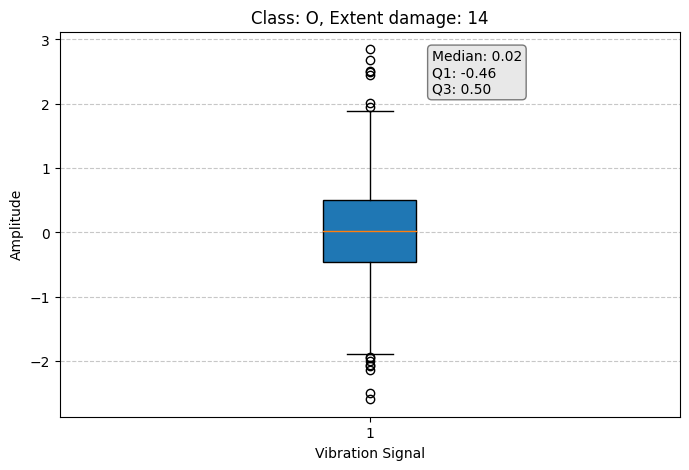

filepath: data/raw/cwru/229.mat


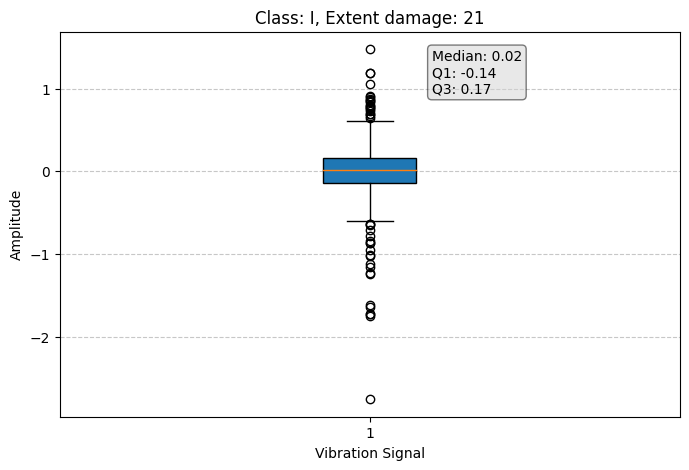

filepath: data/raw/cwru/241.mat


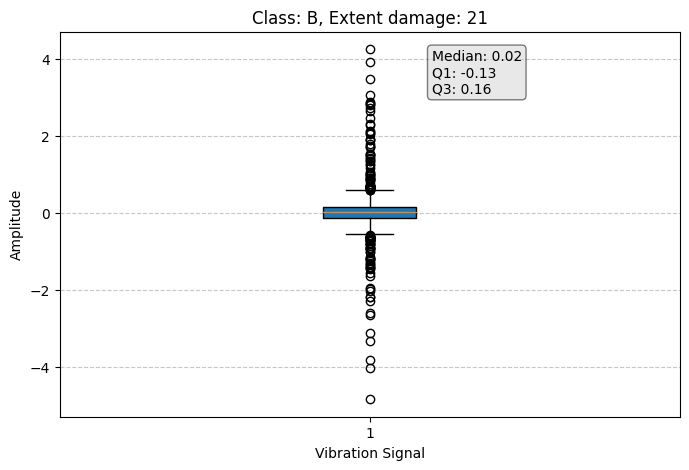

In [4]:
map_title = [("I", "7"), ("B", "7"), ("O", "7"), ("I", "14"), ("B", "14"), ("O", "14"), ("I", "21"), ("B", "21"), ("O", "21")]
filter_files = ["112", "125", "138", "117", "192", "204", "217", "229", "241"]
c = 0
for info in metainfo:
    basename = info["filename"]
    if basename in filter_files:
        filepath = os.path.join('data/raw/', dataset_name.lower(), basename+'.mat')
        print(f"filepath: {filepath}")
        signal, label = dataset.load_signal_by_path(filepath)
        plot_boxplot(signal, title=f"Class: {map_title[c][0]}, Extent damage: {map_title[c][1]}")
        c += 1

In [1]:
import os
def create_directory_structure():
    root_dir = "data/spectrograms/temp"
    for severity in ["007", "014", "021"]:
        for label in ["N", "I", "O", "B"]:
            dir_path = os.path.join(root_dir, severity, label)
            if not os.path.exists(dir_path):
                os.makedirs(dir_path)
    # if not os.path.exists("saved_models"):
    #     os.makedirs("saved_models")

### Processamento de dados

In [51]:
def train_model(model, dataloader, lr, n_epochs, save_path=None):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    cross_entropy_loss = nn.CrossEntropyLoss()
    
    # Training loop
    model.train()
    for epoch in range(n_epochs):  # Number of epochs
        total_loss = 0
        for batch_data, batch_labels in dataloader:

            # Forward pass
            features, outputs = model(batch_data)

            # Cross-entropy loss
            ce_loss = cross_entropy_loss(outputs, batch_labels)            

            # Combine losses
            loss = ce_loss #+ triplet_loss

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch + 1}, Total Loss: {total_loss:.4f}")

    # Saving model
    if save_path:
        torch.save(model.state_dict(), save_path)    


In [52]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt


def validation(model, dataset):
    # Suponha que você tenha um conjunto de dados de validação
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

    # Definir a função de perda (por exemplo, para classificação usamos CrossEntropyLoss)
    criterion = nn.CrossEntropyLoss()   
    model.eval()

    # Variáveis para armazenar perdas e previsões
    validation_loss = 0.0
    all_labels = []
    all_preds = []

    # Desativa a autograd para economizar memória e melhorar a velocidade
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            features, outputs = model(inputs)
            loss = criterion(outputs, labels)  # Define sua função de perda
            
            validation_loss += loss.item() * inputs.size(0)
            
            _, preds = torch.max(outputs, 1)  # Para problemas de classificação
            all_labels.extend(labels.numpy())
            all_preds.extend(preds.numpy())

    # Calcula a perda média
    validation_loss = validation_loss / len(dataloader.dataset)

    # Calcula a acurácia
    accuracy = accuracy_score(all_labels, all_preds)

    print(f'Validation Loss: {validation_loss:.4f}')
    print(f'Accuracy: {accuracy:.4f}')
    # ari_score = adjusted_rand_score(all_labels, all_preds)
    # print(f"ARI: {ari_score:.4f}")


    # Calcula a matriz de confusão
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # Exibir a matriz de confusão usando matplotlib
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

    return accuracy


In [12]:
from src.analysis import plot_clusters, clustering

def get_clusters(dataloader, model):   
    device = "cuda"
    n_clusters = 3
    cluster_centers, features, labels = clustering(model, dataloader, n_clusters, device=device)
    plot_clusters(features, labels, cluster_centers, n_clusters)

In [23]:
from src.analysis import plot_clusters_dual

def get_clusters_dual(dataloader1, dataloader2, model):   
    # Clustering
    device = "cuda" #if torch.cuda.is_available() else "cpu"
    n_clusters = 3
    cluster_centers_1, features_1, labels_1 = clustering(model, dataloader1, n_clusters, device=device)
    cluster_centers_2, features_2, labels_2 = clustering(model, dataloader2, n_clusters, device=device)
    plot_clusters_dual(features_1, labels_1, cluster_centers_1, 
                        features_2, labels_2, cluster_centers_2, 
                        n_clusters, dataset_names=("Dataset 1", "Dataset 2"))


Total samples: 1665
Epoch 1, Total Loss: 40.7006
Epoch 2, Total Loss: 17.4130
Epoch 3, Total Loss: 15.5560
Epoch 4, Total Loss: 13.1775
Epoch 5, Total Loss: 11.7608
Epoch 6, Total Loss: 9.7352
Epoch 7, Total Loss: 11.2483
Epoch 8, Total Loss: 8.1764
Epoch 9, Total Loss: 8.1331
Epoch 10, Total Loss: 9.1225
Epoch 11, Total Loss: 6.4121
Epoch 12, Total Loss: 8.7414
Epoch 13, Total Loss: 7.0221
Epoch 14, Total Loss: 5.7204
Epoch 15, Total Loss: 8.7072
Epoch 16, Total Loss: 10.6172
Epoch 17, Total Loss: 9.3653
Epoch 18, Total Loss: 6.1943
Epoch 19, Total Loss: 5.3663
Epoch 20, Total Loss: 4.8844
Epoch 21, Total Loss: 2.4484
Epoch 22, Total Loss: 4.8562
Epoch 23, Total Loss: 4.9847
Epoch 24, Total Loss: 2.3525
Epoch 25, Total Loss: 1.8010
Epoch 26, Total Loss: 4.1687
Epoch 27, Total Loss: 5.0968
Epoch 28, Total Loss: 4.7914
Epoch 29, Total Loss: 5.7188
Epoch 30, Total Loss: 4.6899
Epoch 31, Total Loss: 1.5739
Epoch 32, Total Loss: 1.0741
Epoch 33, Total Loss: 0.7876
Epoch 34, Total Loss: 3.2

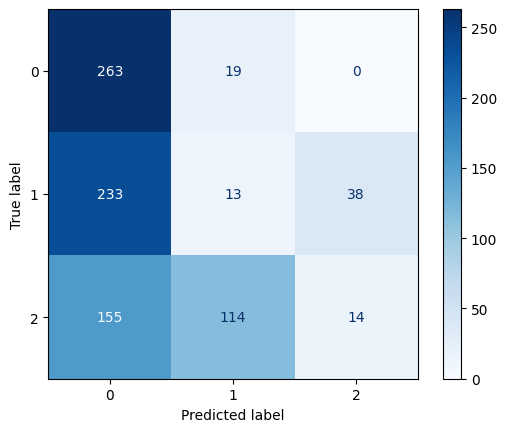

Epoch 1, Total Loss: 41.2767
Epoch 2, Total Loss: 17.7717
Epoch 3, Total Loss: 14.7536
Epoch 4, Total Loss: 13.1541
Epoch 5, Total Loss: 10.9074
Epoch 6, Total Loss: 10.7023
Epoch 7, Total Loss: 9.1873
Epoch 8, Total Loss: 7.6333
Epoch 9, Total Loss: 6.0158
Epoch 10, Total Loss: 7.3086
Epoch 11, Total Loss: 4.4497
Epoch 12, Total Loss: 5.7189
Epoch 13, Total Loss: 6.2014
Epoch 14, Total Loss: 4.0223
Epoch 15, Total Loss: 4.0138
Epoch 16, Total Loss: 6.1362
Epoch 17, Total Loss: 6.2136
Epoch 18, Total Loss: 7.6934
Epoch 19, Total Loss: 6.2007
Epoch 20, Total Loss: 4.2732
Epoch 21, Total Loss: 3.7464
Epoch 22, Total Loss: 2.3648
Epoch 23, Total Loss: 1.3732
Epoch 24, Total Loss: 1.2493
Epoch 25, Total Loss: 4.8213
Epoch 26, Total Loss: 4.8334
Epoch 27, Total Loss: 3.8921
Epoch 28, Total Loss: 6.9241
Epoch 29, Total Loss: 3.7863
Epoch 30, Total Loss: 1.6547
Epoch 31, Total Loss: 2.7120
Epoch 32, Total Loss: 2.5026
Epoch 33, Total Loss: 6.4775
Epoch 34, Total Loss: 5.2557
Epoch 35, Total L

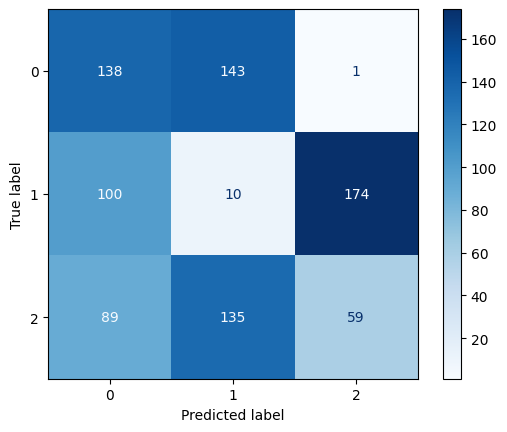

Epoch 1, Total Loss: 40.5808
Epoch 2, Total Loss: 19.6399


KeyboardInterrupt: 

In [57]:
from torch.utils.data import DataLoader, ConcatDataset
from src.data_processing.bearing_dataset import BearingDataset
from src.data_processing.transforms import Scaling, LocalDataReversing, LocalRandomReversing, GlobalDataReversing
from src.models import SignalFeatureCNN1D

dataset_name = "CWRU"
sample_size = 6000

lr = 0.001
n_epochs = 50

data_filter = load_yaml("config/filters_config.yaml")[dataset_name]
# data_filter_uored = load_yaml("config/filters_config.yaml")["UORED"]
# data_filter_hust = load_yaml("config/filters_config.yaml")["Hust"]
data_filter_tr = {**data_filter, "extent_damage":["007", "014"]}
data_filter_te = {**data_filter, "extent_damage":"021"}

dataset_tr = BearingDataset(data_filter_tr, sample_size, sr_original=48000, sr_target=48000, ti_length={"1": 817, "0": 1235, "2": 604})
dataset_te = BearingDataset(data_filter_te, sample_size, sr_original=48000, sr_target=48000)

augmetation = GlobalDataReversing()
dataset_da = BearingDataset(data_filter_tr, sample_size, sr_original=48000, sr_target=48000,
                            ti_length={"0": 453, "1": 453, "2": 689}, transform=augmetation)
dataloader_da = DataLoader(dataset_da, batch_size=32, shuffle=True)

datasets = []
datasets.append(dataset_tr)
# datasets.append(dataset_da)
datasets = ConcatDataset(datasets)


dataloader_tr = DataLoader(dataset_tr, batch_size=32, shuffle=True)

print(f"Total samples: {len(datasets)}")

model = SignalFeatureCNN1D(sample_size)
torch.save(model.state_dict(), "initial_weights.pth")
accuracies = []
for i in range(5):
    model = SignalFeatureCNN1D(sample_size)
    model.load_state_dict(torch.load("initial_weights.pth", weights_only=False))    
    train_model(model, dataloader_tr, lr, n_epochs, save_path="model_f3.pth") # "model_f3.pth"
    accuracy = validation(model, dataset_te)
    accuracies.append(accuracy)
accuracies = np.array(accuracies)
print(f"Total accuracy: {np.mean(accuracies):.4f}")


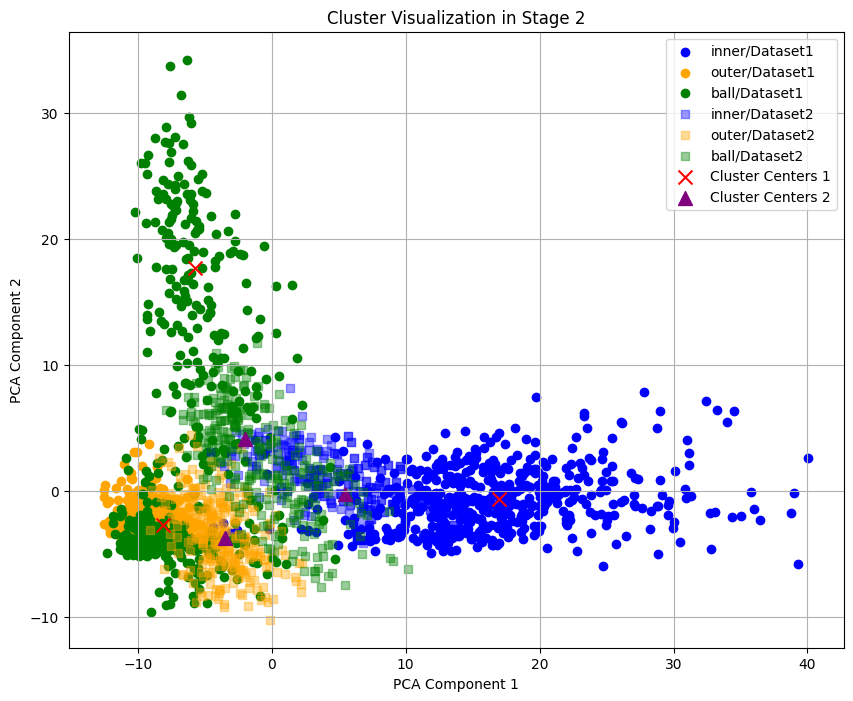

Euclidean distance between cluster centers:
Class I: 9.18207836151123
Class O: 11.5162992477417
Class B: 21.578039169311523


In [60]:
dataloader_te = DataLoader(dataset_te, batch_size=32, shuffle=True)

model = SignalFeatureCNN1D(sample_size)
model.load_state_dict(torch.load("model_f3.pth", weights_only=False))
get_clusters_dual(dataloader_da, dataloader_te, model)

### Clusterização

 **K-means** is a widely used clustering technique, which can effectively estimate the clustering relationship of the recorded samples bycalculating the metric distances between the samples under various healthy conditions. K-means is introduced to cluster the feature distributions of the original labeled samples into several groups attributing to its excellent computational efficiency and the well scalability. The principle of K-means is to iteratively update its inner parameters to minimize the optimization objective as follows.

In [8]:
from sklearn.cluster import KMeans

# K-means clustering algorithm
def apply_kmeans(features, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, n_init='auto', random_state=42)
    kmeans.fit(features)
    return kmeans

In [5]:
# Parameters for UORED
# number_of_balls = 8
# diameter_ball = 6.77
# pitch_diameter = 28.5
# shaft_speed = 1750 / 60 # (Hz)
# sampling_rate = 42000
# sample_size = 420000

### At this stage, data is loaded.

In [11]:
augmetation = Scaling(sigma=0.2)
dataset_da = BearingDataset(data_filter_tr, sample_size, sr_original=48000, sr_target=48000, transform=augmetation)
dataloader_da = DataLoader(dataset_da, batch_size=32, shuffle=True)

In [22]:
# save_model="model.pth"
# model = SignalFeatureCNN1D(sample_size)
# model.load_state_dict(torch.load(save_model, weights_only=True))
# model.eval()

# get_clusters(dataloader, model)

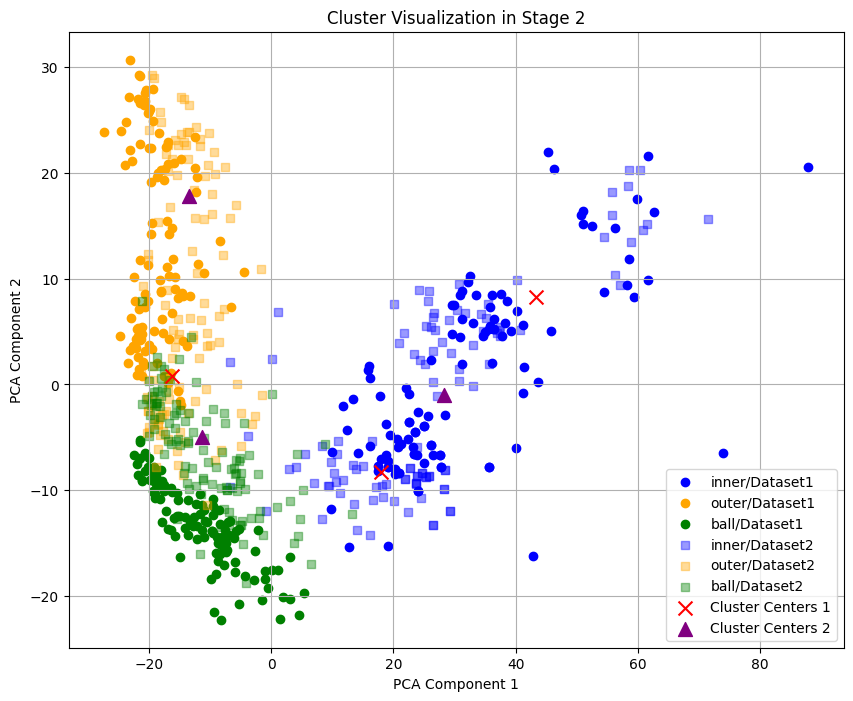

Euclidean distance between cluster centers:
Class I: 40.84132385253906
Class O: 44.61157989501953
Class B: 56.32390213012695


In [23]:
save_model="model.pth"
model = SignalFeatureCNN1D(sample_size)
model.load_state_dict(torch.load(save_model, weights_only=True))
model.eval()

get_clusters_dual(dataloader, dataloader_da, model)

In [24]:
dataset_name = "CWRU"
sample_size = 60000

data_filter = load_yaml("config/filters_config.yaml")[dataset_name]
data_filter_tr = {**data_filter, "extent_damage":["007", "014"]}
data_filter_te = {**data_filter, "extent_damage":"021"}
dataset_tr = BearingDataset(data_filter_tr, sample_size, ti_length={"1": 817, "0": 1235, "2": 604})
dataset_te = BearingDataset(data_filter_te, sample_size)
dataloader_tr = DataLoader(dataset_tr, batch_size=32, shuffle=True)
dataloader_te = DataLoader(dataset_te, batch_size=32, shuffle=True)
len(dataset_te)

84

In [25]:
augmetation = ComposeAugmentations([GlobalDataZoomingLogarithmic(zoom_range=(0.7, 4.0), threshold=0.2)])
dataset_da = BearingDataset(data_filter_tr, sample_size, transform=augmetation)
dataloader_da = DataLoader(dataset_da, batch_size=32, shuffle=True)

In [26]:
# Initialize model
model = SignalFeatureCNN1D(sample_size)

# Training the model
lr = 0.001
n_epochs = 50
save_path = "model_f3_with_da.pth"

dataloader_tr_da = DataLoader(ConcatDataset([dataset_tr, dataset_da]), batch_size=32, shuffle=True)

# train_model(model, dataloader_tr_da, lr, n_epochs, save_path)

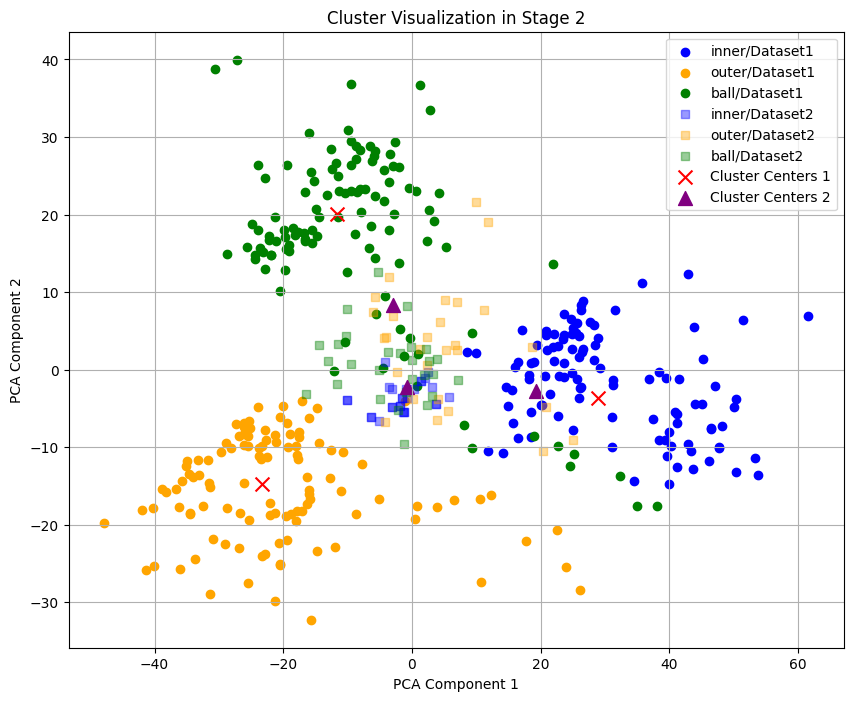

Euclidean distance between cluster centers:
Class I: 25.886093139648438
Class O: 34.01695251464844
Class B: 38.37514877319336


In [27]:
# data augmentation transformation
augmetation = ComposeAugmentations([GlobalDataZoomingLogarithmic(zoom_range=(0.7, 4.0), threshold=0.2)])
dataset_da = BearingDataset(data_filter_tr, sample_size, transform=augmetation)
dataloader_da = DataLoader(dataset_da, batch_size=32, shuffle=True)

save_model="model_f3.pth"
model = SignalFeatureCNN1D(sample_size)
model.load_state_dict(torch.load(save_model, weights_only=True))
model.eval()

get_clusters_dual(dataloader_tr_da, dataloader_te, model)


Validation Loss: 3.1032
Accuracy: 0.3929


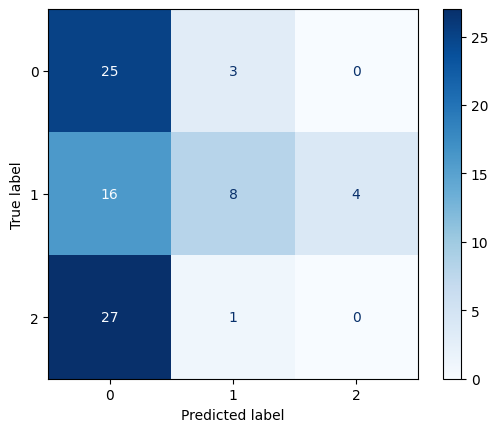

0.39285714285714285

In [28]:
save_model="model_f3.pth"
model = SignalFeatureCNN1D(sample_size)
model.load_state_dict(torch.load(save_model, weights_only=True))
validation(model, dataset_te)